In [1]:
import sys
sys.path.append("..")
from docopt import docopt
import logging
import neptune
import numpy as np
import syft as sy
import torch
from torch import load
from random import seed, sample
from torch import optim, float32, int64, tensor
from torchvision import transforms
from federated_learning.FLNetComplex import FLNetComplex
from federated_learning.FLCustomDataset import FLCustomDataset
from federated_learning.FederatedLearning import FederatedLearning
from federated_learning.helper import utils
CONFIG_PATH = '../configs/defaults.yml'

configs = utils.load_config(CONFIG_PATH)
logging.basicConfig(format='%(asctime)s %(message)s', level=configs['log']['level'])
seed(configs['runtime']['random_seed'])


import matplotlib.pyplot as plt
def draw_samples(data, key):
    data_np = dict()
    print("Drawing for a sample user ({})".format(key))
    data_np['x'] = np.array(data[key]['x'], dtype = np.float32).reshape(-1, 28, 28)
    data_np['y'] = np.array(data[key]['y'], dtype = np.int64).reshape(-1, 1)
    figure = plt.figure(figsize=(10,8))
    for i in range(60):
        plt.subplot(6, 10, i + 1)
        plt.axis("off")
        plt.title(data_np['y'][i])
        plt.imshow(data_np['x'][i], cmap='gray')
        
        
def get_flattted_data(data):
    data_flatted_x = np.array([], dtype = np.float32).reshape(0, 28 * 28)
    tmp_array = [np.array(data_['x'], dtype = np.float32).reshape(-1, 28 * 28) for data_ in data.values()]
    for dd in tmp_array:
        data_flatted_x = np.concatenate((data_flatted_x, dd))
    data_flatted_y = np.array([], dtype = np.float32)
    tmp_array_y = [np.array(data_['y'], dtype = np.int64).reshape(-1) for data_ in data.values()]
    for dd in tmp_array_y:
        data_flatted_y = np.concatenate((data_flatted_y, dd))

    return data_flatted_x, data_flatted_y
        
    
def dataset_info(dataset):
    list_keys = list(dataset.keys())
    numbers = dict()
    # numbers[num_samples] = num_users
    for uu, dd in dataset.items():
        key = str(len(dd['y']))
        if key in numbers:
            numbers[key] += 1
        else:
            numbers[key] = 1
        
    total_samples = 0
    for uu in sorted(numbers.keys()):
        print("{}:\t{}".format(uu, numbers[uu]))
        total_samples += int(uu) * int(numbers[uu])

    print("Mean num of samples/user: {}".format(
        round(np.mean([int(ii) for ii in numbers])), 2))
    print("Total Samples:\t{}".format(total_samples))
    print("Total Users:\t{}".format(len(list_keys)))
    print("[{}]: Images: {}, Pixels: {}".format(
        list_keys[0], 
        len(dataset[list_keys[0]]['x']), 
        len(dataset[list_keys[0]]['x'][0])))
    data_flatted_x, data_flatted_y = get_flattted_data(dataset)
    print("mean: {}\nstd: {},\nmax: {}".format(
            data_flatted_x.mean(), 
            data_flatted_x.std(), 
            data_flatted_x.max()))
    print("-"*5)

In [2]:
# Logging initialization
log_enable = False
output_dir = None
neptune_enable = False

epochs_num = configs['runtime']['epochs']
rounds_num = configs['runtime']['rounds']

fl = FederatedLearning(
        configs['runtime']['server_w0_batch_size'], 
        configs['runtime']['test_batch_size'], 
        configs['runtime']['lr'], 
        configs['runtime']['reg'],
        configs['runtime']['momentum'], 
        neptune_enable, log_enable, 
        configs['log']['interval'], 
        output_dir, 
        configs['runtime']['random_seed'])

fl.create_server()
fl.create_server_model()

raw_train_data = utils.preprocess_leaf_data(
    utils.load_leaf_train(configs['data']['FEMNIST_PATH']), only_digits=True
)
raw_test_data = utils.preprocess_leaf_data(
    utils.load_leaf_test(configs['data']['FEMNIST_PATH']), min_num_samples=configs['runtime']['test_batch_size'], only_digits=True
)

# common users in processed test/train dataset
workers_idx_all = list(set(raw_test_data.keys()).intersection(raw_train_data.keys()))
logging.info("Total of {} workers are in the dataset.".format(len(workers_idx_all)))

workers_idx_to_be_used = utils.get_workers_idx(
    workers_idx_all,
    configs['runtime']['femnist_users_num'],
    []
)
logging.info("Select {} workers to be used from the dataset.".format(len(workers_idx_to_be_used)))

fl.create_workers(workers_idx_to_be_used)
fl.create_workers_model(workers_idx_to_be_used)

# trusted_idx = utils.get_workers_idx(
#     range(total_num_workers), configs['runtime']['mnist_trusted_users_num'], [])
eavesdroppers_idx = utils.get_workers_idx(
                        workers_idx_to_be_used, configs['runtime']['femnist_eavesdropper_num'], [])
normal_idx = utils.get_workers_idx(
                        workers_idx_to_be_used, 
                        len(workers_idx_to_be_used) - int(configs['runtime']['femnist_eavesdropper_num']),
                        eavesdroppers_idx)

# logging.info("Trusted: {}".format(trusted_idx))
logging.info("Eavesdroppers: {}".format(eavesdroppers_idx))
logging.info("Normal: {}".format(normal_idx))
if log_enable:
    utils.write_to_file(output_dir, "all_users", workers_idx_all)
    utils.write_to_file(output_dir, "eavesdroppers", eavesdroppers_idx)
    utils.write_to_file(output_dir, "normal", normal_idx)



2020-12-18 12:09:21,373 Initializing Federated Learning class...
2020-12-18 12:09:21,962 Creating the server...
2020-12-18 12:09:21,963 Creating a model for the server...
2020-12-18 12:09:21,970 Loading train dataset from /home/ubuntu/data/leaf_non_iid/data/femnist/data
2020-12-18 12:09:21,971 Loading 1 out of 5 files...
2020-12-18 12:09:27,457 Loading 2 out of 5 files...
2020-12-18 12:09:32,533 Loading 3 out of 5 files...
2020-12-18 12:09:37,756 Loading 4 out of 5 files...
2020-12-18 12:09:44,592 Loading 5 out of 5 files...
2020-12-18 12:09:49,674 Start processing of femnist data...
2020-12-18 12:09:56,196 Loading test dataset from /home/ubuntu/data/leaf_non_iid/data/femnist/data
2020-12-18 12:09:56,198 Loading 1 out of 5 files...
2020-12-18 12:09:56,703 Loading 2 out of 5 files...
2020-12-18 12:09:57,278 Loading 3 out of 5 files...
2020-12-18 12:09:57,828 Loading 4 out of 5 files...
2020-12-18 12:09:58,463 Loading 5 out of 5 files...
2020-12-18 12:09:58,995 Start processing of femnis

In [7]:
new = utils.perfrom_attack_femnist(
                raw_train_data, 
                1,
                workers_idx_to_be_used,
                eavesdroppers_idx
            )

2020-12-18 03:20:08,499 Find target [f0504_29] for the attack.
2020-12-18 03:20:08,501 Performing attack [shuffle pixels] for user f0504_29...
2020-12-18 03:20:08,515 Find target [f0566_02] for the attack.
2020-12-18 03:20:08,516 Performing attack [shuffle pixels] for user f0566_02...
2020-12-18 03:20:08,521 Find target [f0898_29] for the attack.
2020-12-18 03:20:08,522 Performing attack [shuffle pixels] for user f0898_29...
2020-12-18 03:20:08,530 Find target [f0625_26] for the attack.
2020-12-18 03:20:08,531 Performing attack [shuffle pixels] for user f0625_26...
2020-12-18 03:20:08,537 Find target [f0814_03] for the attack.
2020-12-18 03:20:08,538 Performing attack [shuffle pixels] for user f0814_03...
2020-12-18 03:20:08,543 Find target [f0686_09] for the attack.
2020-12-18 03:20:08,544 Performing attack [shuffle pixels] for user f0686_09...
2020-12-18 03:20:08,548 Find target [f0519_46] for the attack.
2020-12-18 03:20:08,549 Performing attack [shuffle pixels] for user f0519_46...

Drawing for a sample user (f0519_46)


/home/savi/ehsan/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


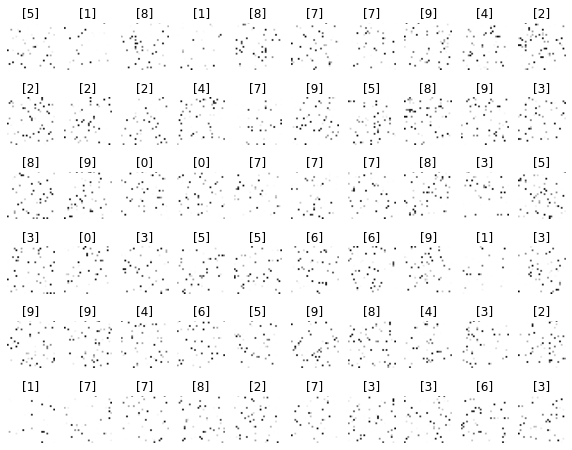

In [8]:
draw_samples(new, eavesdroppers_idx[0])

Drawing for a sample user (f0519_46)


/home/savi/ehsan/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


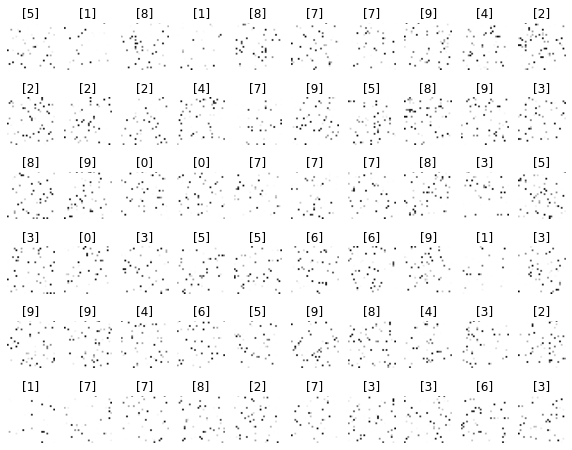

In [9]:
draw_samples(raw_train_data, eavesdroppers_idx[0])

In [ ]:
for ww in list(raw_train_data_new.keys()):
    raw_train_data_new[ww] = 0

In [ ]:
gg=dict()
gg['f0640_19']=dict()
gg['f0640_19']['y'] = raw_train_data['f0640_19']['y']
gg['f0640_19']['x'] = kk
draw_samples(gg)

In [ ]:
kk.shape

In [ ]:
raw_train_data.keys()

In [ ]:
# type(fl.workers['f0557_33'])
cc = torch.utils.data.DataLoader(bb, batch_size=len(bb))
# bb.federate([fl.workers['f0557_33']])

In [ ]:
img = torch.rand(784, dtype=float32)
img = img.reshape(1, 1, 28, 28)
img.shape
ff = FLNetComplex().to(torch.device('cpu'))
ff(img)

In [ ]:
fed_train_dataloader = fl.create_femnist_server_train_dataloader(
    train_dataset, configs['runtime']['server_w0_batch_size'])

# Create test dataloader from all normal and eveasdroppers
# fed_test_dataloader = fl.create_femnist_server_test_dataloader(raw_test_data, workers_idx_to_be_used)

In [ ]:
# Create test dataloader from all normal and eveasdroppers
fed_test_dataloader = fl.create_femnist_server_test_dataloader(raw_test_data, workers_idx_to_be_used)

In [ ]:
print(len(raw_train_data), len(raw_test_data))

In [ ]:
len(eavesdroppers_idx)

In [ ]:
len(workers_idx_all)

In [ ]:
for n, (a, b) in enumerate(test_dataloader):
    print("{}: {}, {}".format(n, a.shape, b.shape))

In [ ]:
utils.dataset_info(raw_train_data)
print()
utils.dataset_info(raw_test_data)

In [ ]:
flattened_data_x, flattened_data_y = utils.get_flattened_data(raw_test_data)

In [ ]:
import matplotlib.pyplot as plt
def draw_samples(data):
    list_keys = list(data.keys())
    data_np = dict()
    data_np['x'] = np.array(data[list_keys[0]]['x'], dtype = np.float32).reshape(-1, 28, 28)
    data_np['y'] = np.array(data[list_keys[0]]['y'], dtype = np.int64).reshape(-1, 1)
    figure = plt.figure(figsize=(8,8))
    for i in range(36):
        plt.subplot(6, 6, i + 1)
        plt.axis("off")
        plt.title(data_np['y'][i])
        plt.imshow(data_np['x'][i], cmap='gray')
        
draw_samples(raw_test_data)

In [ ]:
bb = utils.preprocess_leaf_data(raw_test_data)

In [ ]:
utils.dataset_info(raw_test_data)